# Overview

The task at hand is classification of terrain types from satellite images.
We will use two different approaches:
- A "standard" transfer learning approach where we will build a CNN using a base model (from Imagenet)
- A "bayesian" approach where we will take into account uncertainty on the provided labels

## Workflow

1. [Data Inspection](#inspection) 
    - Loading
    - Inspection
    - Preprocessing
2. [Modeling](#model-definition)
    - Approach 1 : Basic Convolutional net
    - Approach 2 : Transfer Learning using pretrained model
    - Approach 3 : Bayesian Neural Network
3. [Prediction](#prediction)

In [1]:
# Software install (as required)
#!pip install -r ../requirements.txt

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_addons as tfa

/Users/asierabreu/opt/anaconda3/envs/venv/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Inspection <a name="inspection"></a>

In [3]:
# Data Loading : load the EuroSat dataset
# 27000 Sentinel-2 satellite images covering 13 spectral bands. 
# Reference : https://github.com/phelber/eurosat

# load train, test & validation splits into 60%, 20%,20% respectively
(ds_train, ds_test, ds_valid), ds_info   = tfds.load(
    "eurosat", 
    split=["train[:60%]","train[60%:80%]","train[80%:]"],
    as_supervised=True,
    shuffle_files=True,
    with_info=True)

In [4]:
ds_info.features

FeaturesDict({
    'filename': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})

In [5]:
# Basic Info
class_names = ds_info.features["label"].names
num_classes = ds_info.features["label"].num_classes
image_size  = ds_info.features["image"]
print('Total no. of classes : %d' %num_classes)
print('Class labels   : %s' %class_names)
print("Total isntances: %d" %(len(ds_valid)+len(ds_train)+len(ds_test)))
print("Train set size : %d" %len(ds_train)) 
print(" Test set size : %d" %len(ds_test))   
print("Valid set size : %d" %len(ds_valid))
print("")
ds = ds_train.take(1)  # Only take a single example
for image, label in ds: 
  print('image tensor shape: %s' %image.shape)
  print('label tensor type: %s' %label)

Total no. of classes : 10
Class labels   : ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Total isntances: 27000
Train set size : 16200
 Test set size : 5400
Valid set size : 5400

image tensor shape: (64, 64, 3)
label tensor type: tf.Tensor(7, shape=(), dtype=int64)


,image,label
0,,1 (Forest)
1,,7 (Residential)
2,,7 (Residential)
3,,1 (Forest)
4,,0 (AnnualCrop)
5,,8 (River)
6,,2 (HerbaceousVegetation)
7,,0 (AnnualCrop)
8,,1 (Forest)
9,,7 (Residential)

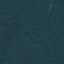
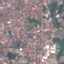
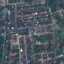
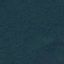
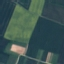
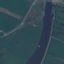
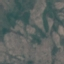
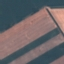
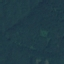
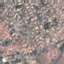

In [6]:
# show a few examples from the train dataset
tfds.as_dataframe(ds_train.take(10), ds_info)

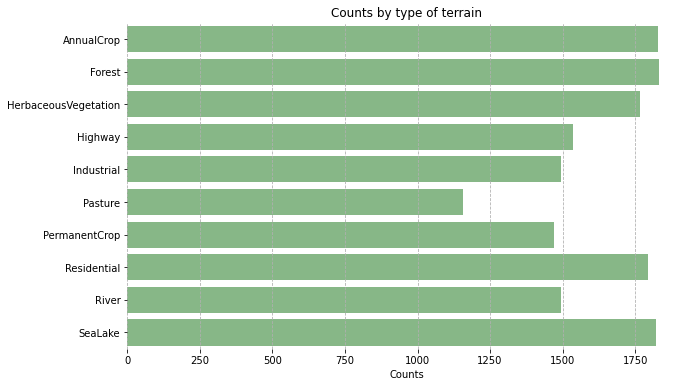

In [8]:
# Class balance check : is the dataset imbalanced?
fig, ax = plt.subplots(1, 1, figsize=(10,6))

labels, counts = np.unique(np.fromiter(ds_train.map(lambda x, y: y), np.int32), 
                       return_counts=True)
ax.set_xlabel('Counts')
ax.grid(True,ls='--')
ax.set_title("Counts by type of terrain");
sns.barplot(x=counts, y=[class_names[l] for l in labels], label="Total",color='green',alpha=0.5)
sns.despine(left=True, bottom=True)

There is not a large imbalance , so data augmentation is not essential here

### Preprocessing

We want to preprocess the images in order to speed up training. Here we :
1. cache 
2. create a tuple of (image,encoded_label) for each image
3. shuffle the inputs
4. batch
5. prefetch

In [9]:
def prepare_for_training(ds, cache=True, batch_size=64, shuffle_buffer_size=1000 , repeat=True):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  # one-hot encode labels
  ds = ds.map(lambda x, y: (x, tf.one_hot(y, num_classes))) # each tensor contains the image(x) and the label(y)
  # shuffle the dataset
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  if repeat:
    # Repeat forever
    ds = ds.repeat()
  # split to batches
  ds = ds.batch(batch_size)
  # `prefetch` lets the dataset fetch batches in the background while the model is training.
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

In [10]:
batch_size = 64
# preprocess training & validation sets
ds_train = prepare_for_training(ds_train, batch_size=batch_size)
ds_valid = prepare_for_training(ds_valid, batch_size=batch_size)

### Model Definition <a name="model definition"></a>

In [11]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [12]:
img_height = 64
img_width = 64
bands = 3 

### Approach 1: Basic net
  1. We use standard CNN with initial rescaling , and convolutional and maxpooling layers with relu activation
  2. Standard softmax classification layer

In [13]:

num_classes = len(class_names)

model1 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, bands)),
  layers.Conv2D(16, bands, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, bands, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, bands, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model1.compile(
    loss="categorical_crossentropy", 
    optimizer="adam", 
    metrics=["accuracy", tfa.metrics.F1Score(num_classes)]
)

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0

### Approach 2: Pre-trained net
  1. We use a base model (pretrained neural net for the imagenet challenge and specify that is trainable
  2. We add a top model with a softmax classification layer 

In [14]:
# BASE MODEL (ImageNet)
model_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2"
# download & load the layer as a feature vector
base_model = hub.KerasLayer(model_url, output_shape=[1280], trainable=True, name='base_layer')

In [19]:
model2 = Sequential([
  base_model,
  layers.Dense(num_classes, activation="softmax", name="classification_layer")
])
# build the model with input image shape as (64, 64, 3)
model2.build([None, 64, 64, 3])
model2.compile(
    loss="categorical_crossentropy", 
    optimizer="adam", 
    metrics=["accuracy", tfa.metrics.F1Score(num_classes)]
)

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base_layer (KerasLayer)      (None, 1280)              117746848 
_________________________________________________________________
classification_layer (Dense) (None, 10)                12810     
Total params: 117,759,658
Trainable params: 117,247,082
Non-trainable params: 512,576
_________________________________________________________________


### Model Training <a name="model training"></a>

In [16]:
verbose=1
epochs=10
# set the training & validation steps since we're using .repeat() on our dataset
# number of training steps
n_training_steps   = int(27000 * 0.6) // batch_size
# number of validation steps
n_validation_steps = int(27000 * 0.2) // batch_size

In [17]:
# Train Model 1
model_name = "image-classification-model1"
model_path = os.path.join("../models", model_name + ".h5")
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, save_best_only=True, verbose=1)
# train the model
history1 = model1.fit(
    ds_train, 
    validation_data=ds_valid,
    steps_per_epoch=n_training_steps,
    validation_steps=n_validation_steps,
    epochs=epochs, 
    callbacks=[model_checkpoint]
)

Epoch 1/10
254/254 [==============================] - 31s 120ms/step - loss: 9.1007 - accuracy: 0.1127 - f1_score: 0.0209 - val_loss: 9.3724 - val_accuracy: 0.1061 - val_f1_score: 0.0192

Epoch 00001: val_loss improved from inf to 9.37237, saving model to ../models/image-classification-model2.h5
Epoch 2/10
254/254 [==============================] - 30s 118ms/step - loss: 9.2271 - accuracy: 0.1129 - f1_score: 0.0203 - val_loss: 9.3724 - val_accuracy: 0.1061 - val_f1_score: 0.0192

Epoch 00002: val_loss did not improve from 9.37237
Epoch 3/10
254/254 [==============================] - 31s 122ms/step - loss: 9.2271 - accuracy: 0.1129 - f1_score: 0.0203 - val_loss: 9.3724 - val_accuracy: 0.1061 - val_f1_score: 0.0192

Epoch 00003: val_loss did not improve from 9.37237
Epoch 4/10
254/254 [==============================] - 35s 138ms/step - loss: 9.2271 - accuracy: 0.1129 - f1_score: 0.0203 - val_loss: 9.3724 - val_accuracy: 0.1061 - val_f1_score: 0.0192

Epoch 00004: val_loss improved from 9

In [18]:
# Train Model 2
model_name = "image-classification-model2"
model_path = os.path.join("../models", model_name + ".h5")
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, save_best_only=True, verbose=1)
# train the model
history2 = model2.fit(
    ds_train, 
    validation_data=ds_valid,
    steps_per_epoch=n_training_steps,
    validation_steps=n_validation_steps,
    epochs=epochs, 
    callbacks=[model_checkpoint]
)

Epoch 1/10
253/253 [==============================] - 33s 126ms/step - loss: 7.4368 - accuracy: 0.1101 - f1_score: 0.0210 - val_loss: 8.0740 - val_accuracy: 0.1064 - val_f1_score: 0.0192

Epoch 00001: val_loss improved from inf to 8.07404, saving model to ../models/image-classification-model2.h5
Epoch 2/10
253/253 [==============================] - 31s 122ms/step - loss: 8.0600 - accuracy: 0.1130 - f1_score: 0.0203 - val_loss: 8.0890 - val_accuracy: 0.1060 - val_f1_score: 0.0192

Epoch 00002: val_loss did not improve from 8.07404
Epoch 3/10
196/253 [======================>.......] - ETA: 6s - loss: 8.0462 - accuracy: 0.1140 - f1_score: 0.0205

KeyboardInterrupt: 

### Model Evaluation <a name="model evaluation"></a>